In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from gradcam import make_gradcam_heatmap, create_gradcam_visualization
from utils import train_model

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

y_train = y_train.flatten()
y_test = y_test.flatten()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

2025-12-17 15:29:59.668845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765985400.993257    6369 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765985401.352048    6369 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765985404.605519    6369 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765985404.605547    6369 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765985404.605549    6369 computation_placer.cc:177] computation placer alr

In [2]:
base_model = keras.applications.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

for layer in base_model.layers[::-1]:
    if 'conv' in layer.name or 'activation' in layer.name:
        last_conv_layer_name = layer.name
        break

print(f"Using layer: {last_conv_layer_name}")

I0000 00:00:1765985432.245639    6369 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14793 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


Using layer: top_activation


In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,415,088 (24.47 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

 Optimizer params: 330,518 (1.26 MB)

In [3]:
X_train_resized = np.array([keras.preprocessing.image.smart_resize(img, (224, 224)) for img in X_train[:5000]])
X_test_resized = np.array([keras.preprocessing.image.smart_resize(img, (224, 224)) for img in X_test[:1000]])

X_train_preprocessed = keras.applications.efficientnet_v2.preprocess_input(X_train_resized)
X_test_preprocessed = keras.applications.efficientnet_v2.preprocess_input(X_test_resized)

model, history = train_model(
    model, 
    X_train_preprocessed, 
    y_train[:5000],
    model_name='cifar10_efficientnet',
    epochs=10,
    early_stopping=False
)

2025-12-17 15:30:49.200171: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2408448000 exceeds 10% of free system memory.
2025-12-17 15:30:49.777287: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2408448000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1765985458.086157    6666 service.cc:152] XLA service 0x79d1001146d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765985458.086188    6666 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-12-17 15:30:58.567158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765985460.476201    6666 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1765985474.662408    6666 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.5726 - loss: 1.3054 - val_accuracy: 0.8560 - val_loss: 0.4239
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8391 - loss: 0.4739 - val_accuracy: 0.8710 - val_loss: 0.3775
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8611 - loss: 0.3948 - val_accuracy: 0.8800 - val_loss: 0.3504
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8925 - loss: 0.3200 - val_accuracy: 0.8860 - val_loss: 0.3398
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9062 - loss: 0.2801 - val_accuracy: 0.8870 - val_loss: 0.3332
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9135 - loss: 0.2595 - val_accuracy: 0.8780 - val_loss: 0.3330
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9207 - loss: 0.2426 - val_accuracy: 0.8920 - val_loss: 0.3214
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.9272 - loss: 0.2136 - val_accuracy: 0.8

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
True: cat
Predicted: cat (0.9819)


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


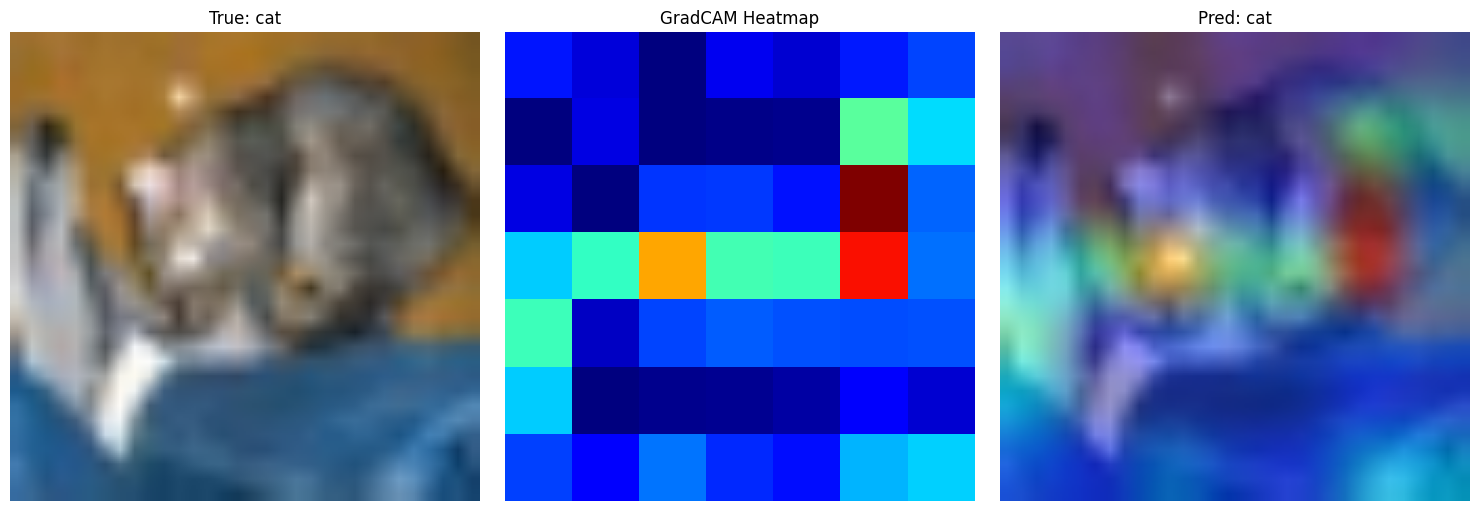

In [4]:
img_idx = 0
img_original = X_test[img_idx]
img = X_test_resized[img_idx]
img_preprocessed = X_test_preprocessed[img_idx]
true_label = y_test[img_idx]

img_array = np.expand_dims(img_preprocessed, axis=0)
preds = model.predict(img_array)
pred_label = np.argmax(preds[0])

print(f"True: {class_names[true_label]}")
print(f"Predicted: {class_names[pred_label]} ({preds[0][pred_label]:.4f})")

heatmap = make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img.astype('uint8'))
axes[0].set_title(f"True: {class_names[true_label]}")
axes[0].axis('off')

axes[1].imshow(heatmap, cmap='jet')
axes[1].set_title("GradCAM Heatmap")
axes[1].axis('off')

superimposed = create_gradcam_visualization(img, heatmap)
axes[2].imshow(superimposed)
axes[2].set_title(f"Pred: {class_names[pred_label]}")
axes[2].axis('off')

plt.tight_layout()
plt.show()

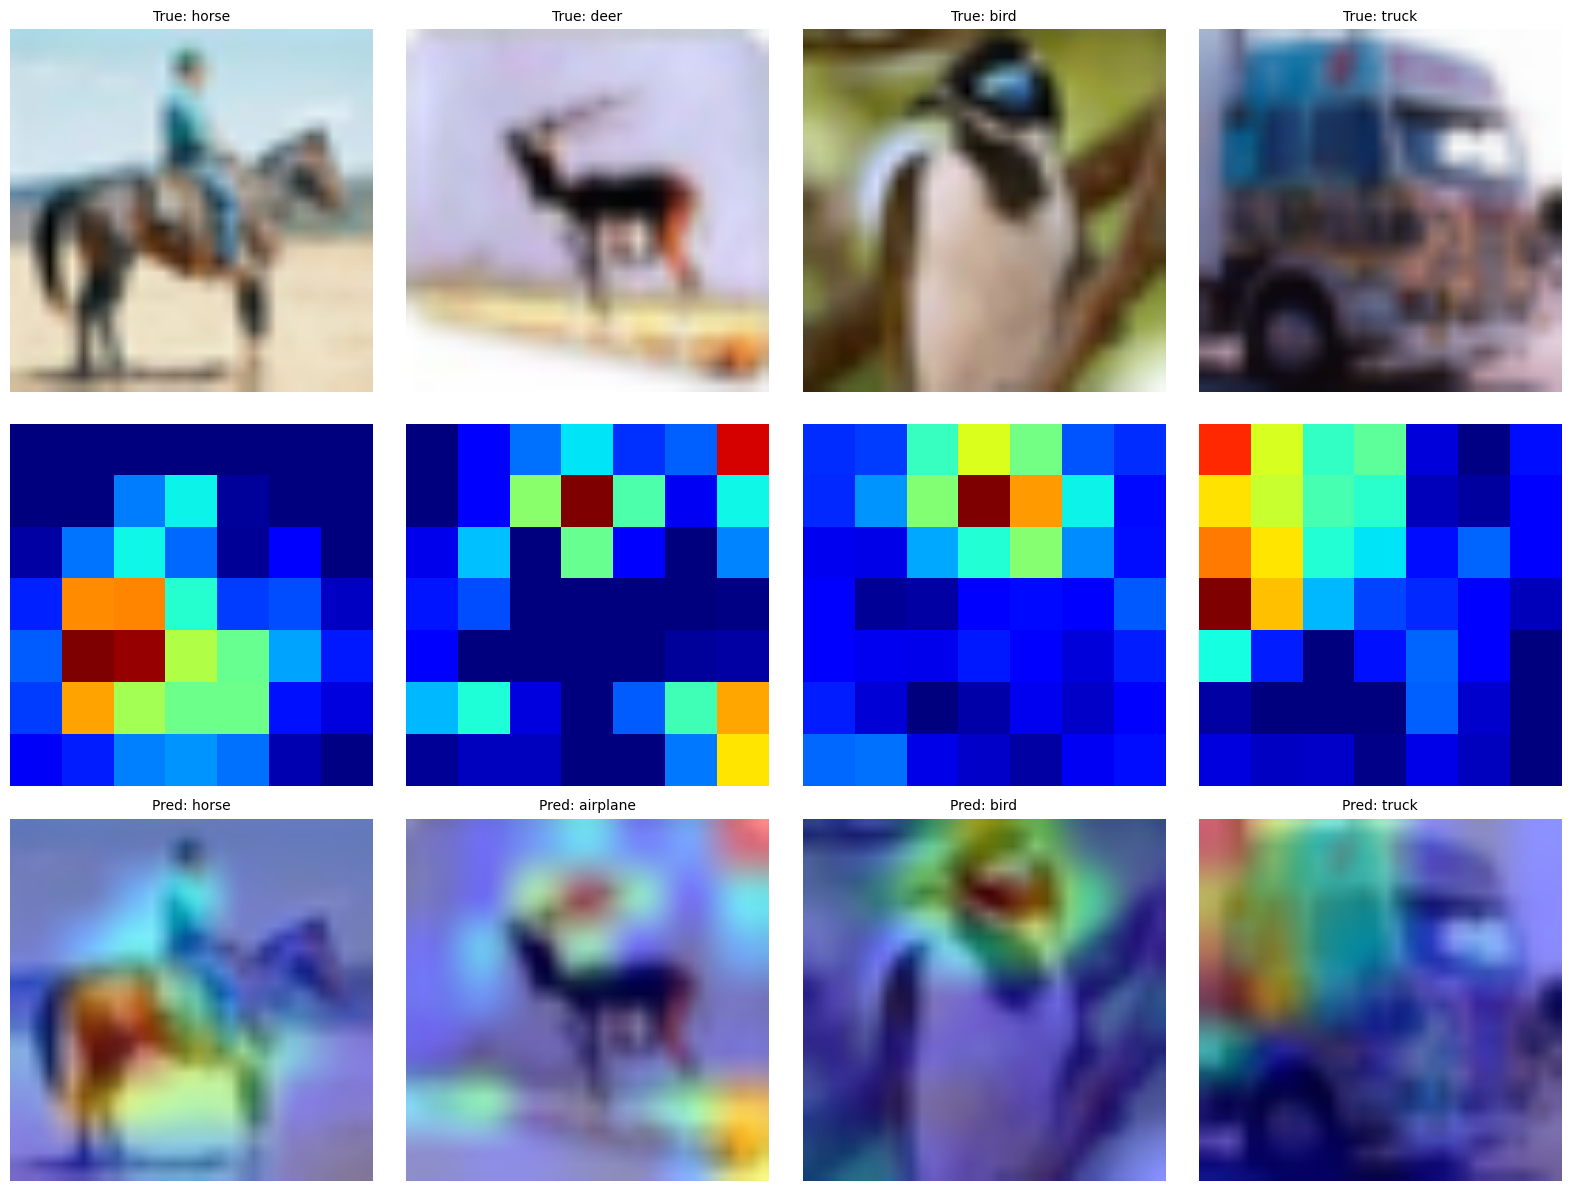

In [5]:
np.random.seed(42)
indices = np.random.choice(len(X_test_resized), 4, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for col, idx in enumerate(indices):
    img = X_test_resized[idx]
    img_preprocessed = X_test_preprocessed[idx]
    true_label = y_test[idx]
    
    img_array = np.expand_dims(img_preprocessed, axis=0)
    preds = model.predict(img_array, verbose=0)
    pred_label = np.argmax(preds[0])
    
    heatmap = make_gradcam_heatmap(img_array, model, base_model, last_conv_layer_name)
    superimposed = create_gradcam_visualization(img, heatmap)
    
    axes[0, col].imshow(img.astype('uint8'))
    axes[0, col].set_title(f"True: {class_names[true_label]}", fontsize=10)
    axes[0, col].axis('off')
    
    axes[1, col].imshow(heatmap, cmap='jet')
    axes[1, col].axis('off')
    
    axes[2, col].imshow(superimposed)
    axes[2, col].set_title(f"Pred: {class_names[pred_label]}", fontsize=10)
    axes[2, col].axis('off')

plt.tight_layout()
plt.show()